In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels. api as sm
import statsmodels.formula.api as smf
import sys, os
import ast
import re
import seaborn as sns
import inspect

In [3]:
CURRENTDIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))))
results = pd.read_excel(os.path.join(CURRENTDIR,"data/extracted_data.xlsx"))

# Loading sklearn Scalers & PCA

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [5]:
results.columns

Index(['file', 'locutor', 'block', 'conv', 'it', 'conv_id_unif', 'tier',
       'count_syllables', 'extract_sentiment', 'extract_subjectivity',
       'lexical_richness', 'linguistic_complexity', 'mean_ipu_lgth', 'nb_ipu',
       'nb_tokens', 'qt_discourse', 'qt_feedback', 'qt_filled_pause',
       'ratio_discourse', 'ratio_feedback', 'ratio_filled_pause',
       'ratio_silence_lgth', 'speech_rate', 'speech_rate_2', 'speech_rate_max',
       'speech_rate_mean', 'speech_rate_min', 'sum_ipu_lgth', 'extract_text'],
      dtype='object')

In [6]:
int_cols = ['count_syllables', 
       'lexical_richness', 'linguistic_complexity', 'mean_ipu_lgth', 'nb_ipu',
       'nb_tokens', 'ratio_discourse', 'ratio_feedback', 'ratio_filled_pause',
       'ratio_silence_lgth', 'speech_rate', 'speech_rate_mean', 'sum_ipu_lgth']
labels = 'locutor'
select_tier = 'participant'

In [39]:
X_H = results[(results.tier == select_tier) & (results.conv == 1)][int_cols]
X_R = results[(results.tier == select_tier) & (results.conv == 2)][int_cols]
y_H = results[(results.tier == select_tier) & (results.conv == 1)][labels]
y_R = results[(results.tier == select_tier) & (results.conv == 2)][labels]

In [40]:
X_Hs = StandardScaler().fit_transform(X_H)

In [41]:
X_Hs.shape

(297, 13)

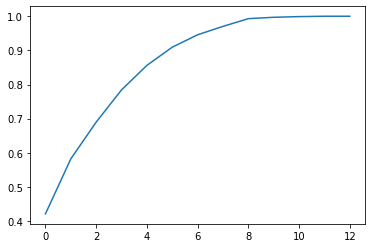

In [42]:
pca = PCA()
pca.fit(X_Hs)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

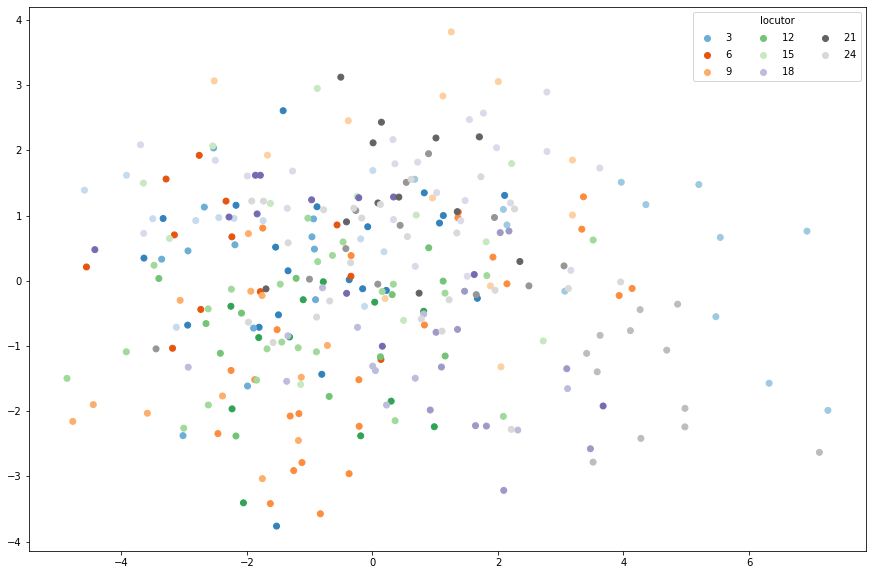

In [45]:
X_Hss = pca.transform(X_Hs)
fig, ax = plt.subplots(figsize = (15,10))
scat = ax.scatter(X_Hss[:,0], X_Hss[:,1], c=y_H, cmap=plt.get_cmap('tab20c'))
legend = ax.legend(*scat.legend_elements(), loc="best", title=labels, ncol=3)
plt.show()

First two PCA components represent a very low share of the total variance still some patterns appear.

In [48]:
y_H2 = results[(results.tier == select_tier) & (results.conv == 1)].apply(lambda x: "{}_{}".format(x.locutor, x.conv_id_unif), axis=1).values

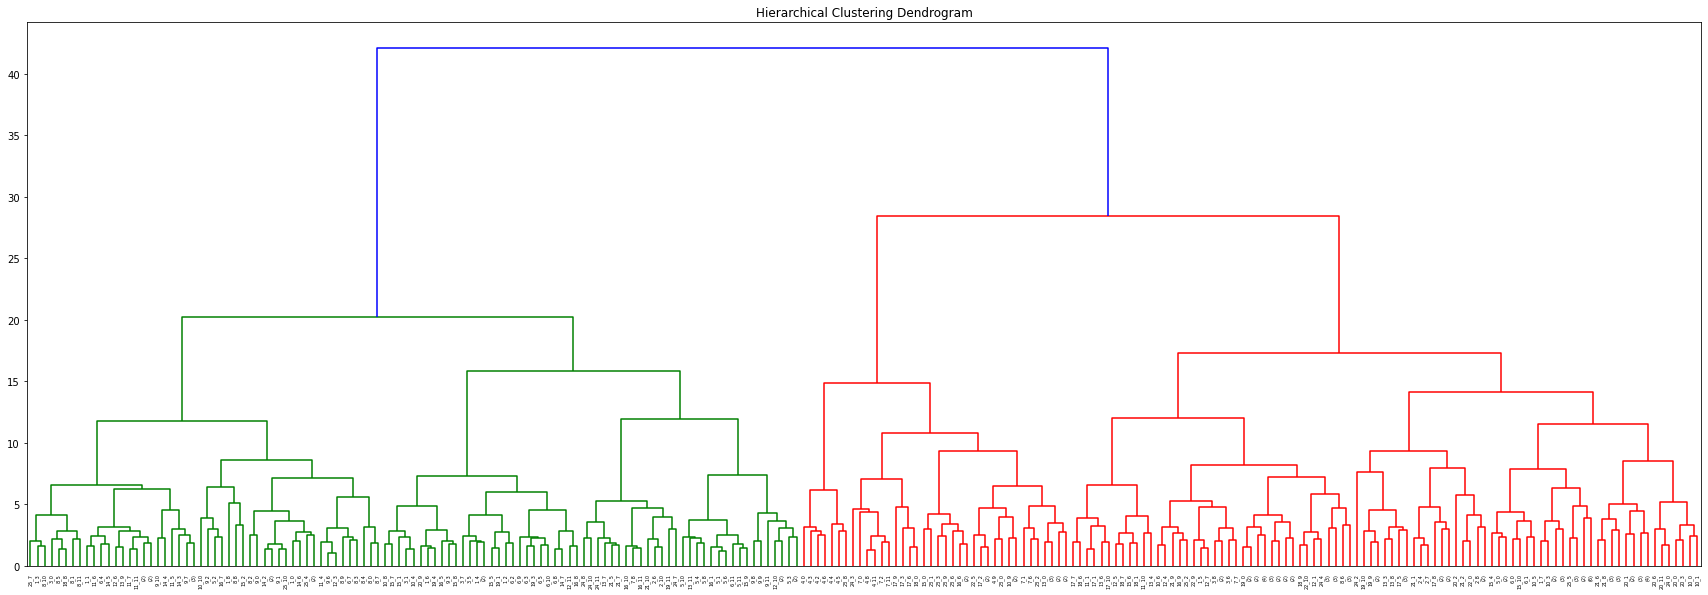

In [50]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, index, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0]) 
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples: 
                current_count += 1 # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float) 
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, labels=index, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pd.DataFrame(X_Hss, index=y_H2))
_ = plt.subplots(figsize=(30,10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram 
plot_dendrogram(model, y_H2, truncate_mode='level', p=8) 
plt.show()

Conclusion: some individual clusters